# Stack Overflow Survey Analysis 

Every year Stack Overflow releases a survey made amongst its users and which covers a large panel of questions - from the salary to the experience, the language used or the use of the website.

What interested me was how the people answered about their career satisfaction and how this perception had evolved over the last few years - since 2017 to be precise. SO the question I wanted to answer to were the following :
1. what factors have an impact on the career satisfaction. 
2. how does the career satisfaction evolve with the age
3. is the career satisfaction deeply related to the salary

### Library importation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline
scaler = StandardScaler()

In [2]:
df_19 = pd.read_csv("developer_survey_2019/survey_results_public.csv")
df_19.shape

(88883, 85)

# Exploratory Analysis

In [3]:
df_19.head(1)

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult


In [4]:
#proportion of missing values per question (top 30)
(df_19.isnull().sum()/df_19.shape[0]).sort_values(ascending=False).head(30)

BlockchainOrg             0.457995
CodeRevHrs                0.439825
ConvertedComp             0.371950
CompTotal                 0.370577
MiscTechWorkedWith        0.329613
BlockchainIs              0.323099
PurchaseHow               0.312489
MgrMoney                  0.311938
MgrIdiot                  0.311916
MgrWant                   0.311094
PurchaseWhat              0.302128
UnitTests                 0.294938
WebFrameDesireNextYear    0.291833
CompFreq                  0.288188
WorkWeekHrs               0.274293
MiscTechDesireNextYear    0.274203
WebFrameWorkedWith        0.268454
LastInt                   0.244456
WorkChallenge             0.233363
SOHowMuchTime             0.230697
WorkPlan                  0.224666
DatabaseDesireNextYear    0.222045
SONewContent              0.217398
WorkLoc                   0.211829
WorkRemote                0.209253
CodeRev                   0.208060
JobSat                    0.201332
FizzBuzz                  0.197327
CurrencyDesc        

In [5]:
#data type
df_19.dtypes.value_counts()

object     79
float64     5
int64       1
dtype: int64

In [6]:
df_19.select_dtypes(exclude=["object"]).columns

Index(['Respondent', 'CompTotal', 'ConvertedComp', 'WorkWeekHrs', 'CodeRevHrs',
       'Age'],
      dtype='object')

The Respondent variable is just an identifier and will not help us in modeling so we will drop it in the process. 
Al the other variables are "object" type and have different levels : we will hav to decide wether we want to recode them or to use dummy variables - the later implying increasing the size of our dataset.

In [7]:
#age of the population
df_19.Age.describe()

count    79210.000000
mean        30.336699
std          9.178390
min          1.000000
25%         24.000000
50%         29.000000
75%         35.000000
max         99.000000
Name: Age, dtype: float64

Text(0.5, 1.0, "Distribution of the population's age")

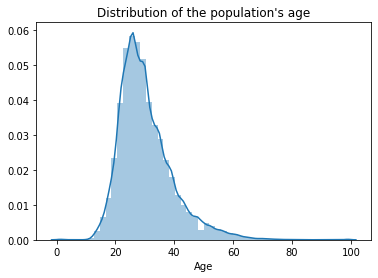

In [8]:
sb.distplot(df_19.Age)
plt.title("Distribution of the population's age")

In [9]:
#origin of the population
df_19.ConvertedComp.describe()

count    5.582300e+04
mean     1.271107e+05
std      2.841523e+05
min      0.000000e+00
25%      2.577750e+04
50%      5.728700e+04
75%      1.000000e+05
max      2.000000e+06
Name: ConvertedComp, dtype: float64

## Q1. what are the factors relevant for the career satisfaction

### Cleaning data

In [10]:
df_19.head(1)

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult


In [11]:
df_19.shape

(88883, 85)

After looking at the questions of the dataset, it realized some - such as the evolution wanted or the interview process - were very unlikely to be correlated with the career satisfaction so I decided to drop them. Furthermore I only kept the rows were the answer to the career satisfaction was given.

In [12]:
#variables to drop
drop_col = ["OpenSourcer", "OpenSource", "EduOther", "Age1stCode", "MgrMoney", "MgrWant", "LastInt", "FizzBuzz",
           "JobFactors", "ResumeUpdate", "CurrencySymbol", "CurrencyDesc", "WorkLoc", "PurchaseHow", 
           "LanguageDesireNextYear", "DatabaseDesireNextYear", "PlatformDesireNextYear", "WebFrameDesireNextYear",
           "MiscTechDesireNextYear", "Containers", "BlockchainIs", "BetterLife", "OffOn", "SocialMedia", 
           "ScreenName", "SOVisit1st", "SOVisitFreq", "SOVisitTo", "SOFindAnswer", "SOTimeSaved", "SOHowMuchTime",
           "SOAccount", "SOPartFreq","SOJobs", "EntTeams", "SOComm", "WelcomeChange", "SONewContent", 
           "SurveyLength", "SurveyEase", "Respondent"]

In [13]:
def clean_data(df, drop_col=None):
    """
    Function to prepare the data by dropping undesirable columns and filling the missing values
    INPUT
    df - original dataframe
    drop_col - list of columns, default value to None
    
    OUTPUT
    y - target of the model as a dataframe
    X - scaled explicative variable as a dataframe
    """ 
    #keep the observation not missing and rename CareerSat into "label"
    if "CareerSat" in df.columns:
        df_return = df[df.loc[:, "CareerSat"].notnull()]
        df_return = df_return.rename(columns={"CareerSat":"label"})
    else:
        df_return = df
    
    #drop the unnecessary columns
    if drop_col != None:
        df_return.drop(drop_col, axis=1, inplace=True)
    
    #missing values in numeric variables : fill with the mean and scale
    numVar = df_return.select_dtypes(exclude=["object"]).columns
    for var in numVar:
        df_return.loc[:, var] = df_return.loc[:, var].fillna(df_return.loc[:, var].mean())
    
    #categorical variables : recode into numerical variable; dummy variables would create a too big dataset
    catVar = df_return.select_dtypes(include=["object"]).columns
    for var in catVar:
        df_return.loc[:, var] = pd.factorize(df_return[var])[0]
    
    #distinction between target and features
    y = df_return["label"]
    X = df_return.drop("label", axis=1)
    
    #column names
    col_names = X.columns.tolist()
    
    #scale the data but the label
    scaler.fit(X)
    X = scaler.transform(X)
    
    return pd.DataFrame(y), pd.DataFrame(X, columns=col_names)

In [14]:
y, X = clean_data(df_19, drop_col)
y.shape, X.shape, df_19.shape

((72847, 1), (72847, 43), (88883, 85))

### Modeling

In [15]:
#split between train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y.values.ravel(), 
                                                    random_state=42)

In [16]:
#initialize the different models
rf_mod = RandomForestClassifier(n_estimators=200)
bag_mod = BaggingClassifier(n_estimators=200)
ada_mod = AdaBoostClassifier(n_estimators=300, learning_rate=0.2)

In [17]:
#train and evaluate the performance of the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Function to evaluate the quality of a model with the f1 score for multiclass classification
    INPUT
    model - model to evaluate
    X_train - features of the training dataset
    y_train - target of the training dataset
    X_test - features of the testing dataset
    y_test - target of the testing dataset
    
    OUTPUT
    trained_model - model after training
    preds - predictions on the testing set
    f1_score - f1_score of the model on the testing set
    """
    #fit the model
    model.fit(X_train, y_train)
    
    #make predictions on the test dataset
    preds = model.predict(X_test)
    
    #calculate the f1 score
    model_f1_score = f1_score(y_test, preds, average="weighted")
    
    return model, preds, model_f1_score

In [18]:
rf_mod, rf_preds, rf_f1 = evaluate_model(rf_mod, X_train, y_train, X_test, y_test)
bag_mod, bag_preds, bag_f1 = evaluate_model(bag_mod, X_train, y_train, X_test, y_test)
ada_mod, ada_preds, ada_f1 = evaluate_model(ada_mod, X_train, y_train, X_test, y_test)

In [19]:
#performance of our models with the f1 score
print("random forest f1 score : {}".format(rf_f1))
print("bagging classifier f1 score : {}".format(bag_f1))
print("adaboost f1 score : {}".format(ada_f1))

random forest f1 score : 0.5384111367824279
bagging classifier f1 score : 0.5749254577177102
adaboost f1 score : 0.5619967538416846


The bagging classifier has the best f1 score : we will use this model from now on.  
We will now try to improve its score and to make it faster by removing non significant features.

In [20]:
#feature importance
def feature_importance(model):
    """
    Function to get the features importance
    INPUT
    model - model trained
    
    OUTPUT
    features_importance_df - dataframe of the features and their importance in the model
    """
    features = np.stack([estimator.feature_importances_ for estimator in model.estimators_], axis=0)
    features_importance = np.mean(features, axis=0).tolist()

    features_name = X_train.columns.values.tolist()

    features_importance_df = pd.DataFrame.from_dict({"name": features_name, "importance":features_importance})
    features_importance_df.sort_values(by="importance", ascending=False, inplace=True)
    return features_importance_df

In [21]:
feature_importance_19 = feature_importance(bag_mod)

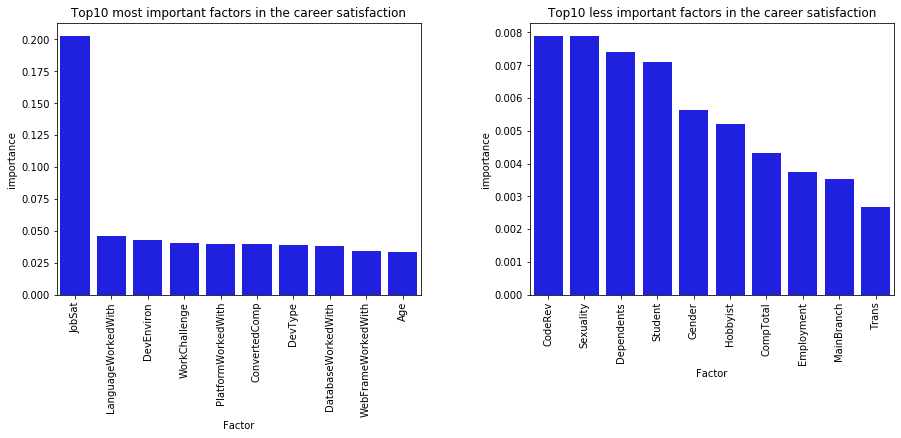

In [22]:
figure = plt.figure(figsize=(15,5))
plt.gcf().subplots_adjust(wspace=0.3)

plt.subplot(1, 2, 1)
sb.barplot(x="name", y="importance", data=feature_importance_19.head(10), color="blue")
plt.xticks(rotation=90)
plt.title("Top10 most important factors in the career satisfaction")
plt.xlabel("Factor")

plt.subplot(1, 2, 2)
sb.barplot(x="name", y="importance", data=feature_importance_19.tail(10), color="blue")
plt.xticks(rotation=90)
plt.title("Top10 less important factors in the career satisfaction")
plt.xlabel("Factor");

The most important factor in the career satisfaction is the job satisfaction. It seems logical that one should be happier if he is correctly employed than if his work does not suit his desires.  
After this factor, there is no huge difference between the difference of the other factors. We can see than the work environment - the tools and the chalenges faced - are important but the difference is tiny.  
Still we can see that the age comes as the 10th most important factor - which implies our next question is relevant.  

On the other hand, there are quite a number of non significant factors.  
We could be surprised by the presence of the employment factor, but if unemployed people did not answer the career satisfaction question or if they are too few in our population then the employment might not be significant.  
We can also find the CompTotal factor in this list. While it might be a surprise as well, it si quite understandable given that this salary is given in different currency according to the country. It is probably more relevant to use the ConvertedComp - which appears as the 6th most important factor.

## Q2. how does evolve the career satisfaction with the age

In [23]:
df_age = df_19[["Age", "Respondent", "CareerSat"]]
df_age = df_age[df_age.loc[:, "CareerSat"].notnull()]

df_age = df_age.groupby(["CareerSat", "Age"]).count().reset_index().rename(columns={"Respondent":"count"})

df_age.Age.drop_duplicates().count(), df_age.CareerSat.drop_duplicates().count()

(104, 5)

104 levels for the age, 5 for the career satisfaction : this is too much for plotting it so we have to regroup the ages.

In [24]:
#regroup ages
bins = [0, 20, 30, 40, 50, 60, 70, 120]
labels = ["-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70+"]
df_age["age_grouped"] = pd.cut(df_age.Age, bins, labels=labels, include_lowest=True)
df_age["frequency"] = df_age.count

In [25]:
df_age2 = df_age.groupby(["age_grouped", "CareerSat"])["count"].count().reset_index()
df_age2 = df_age2.pivot(index="age_grouped", columns="CareerSat", values="count").reset_index()

#assess the frequency of each group
df_age2["total"] = df_age2.sum(axis=1)
for col in df_age2.drop(["total", "age_grouped"], axis=1).columns:
    df_age2[col] = df_age2[col] / df_age2["total"]

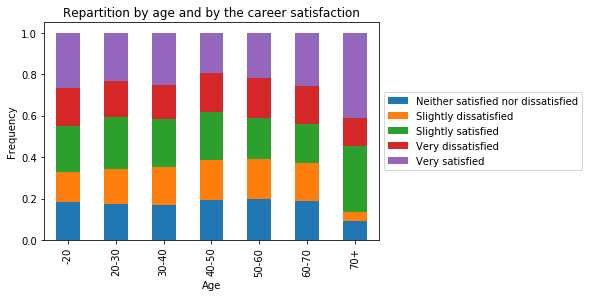

In [26]:
df_age2.drop("total", axis=1).set_index("age_grouped").plot(kind="bar", stacked=True, legend=False)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.title("Repartition by age and by the career satisfaction")
plt.ylabel("Frequency")
plt.xlabel("Age");

In [27]:
df_age.groupby("age_grouped")["count"].count()

age_grouped
-20      49
20-30    64
30-40    60
40-50    52
50-60    51
60-70    43
70+      22
Name: count, dtype: int64

The proportion of very satisfied people decreases slightly with the age until the age of 50 and then it increases until the retirement - where 40% of the population is happy with his career. One reason could be that at the beginning of our career we can see a lot of different subject while the older me get the more stuck we get on our subjects and the less interesting it becomes.  
On the other hand, the proportion of dissatisfied people is stable and drops at the retirement because people are still happy to be retired.  
The balance is obtained by the small increase of the people who do not have an opinion.  
However these observations are to be minded cautiously because of the small number of people who gave their age - so this sample might not correctly represents the whole population.

## Q3. is the career satisfaction deeply related to the salary

To answer this question, we will use the ConvertedComp column - which is the salary converted to USD - in order to be able to compare the situations of workers in countries with different currencies.

In [28]:
df_salary = df_19[["CareerSat", "ConvertedComp"]]

#remove missing values
df_salary = df_salary[df_salary.ConvertedComp.notnull()]

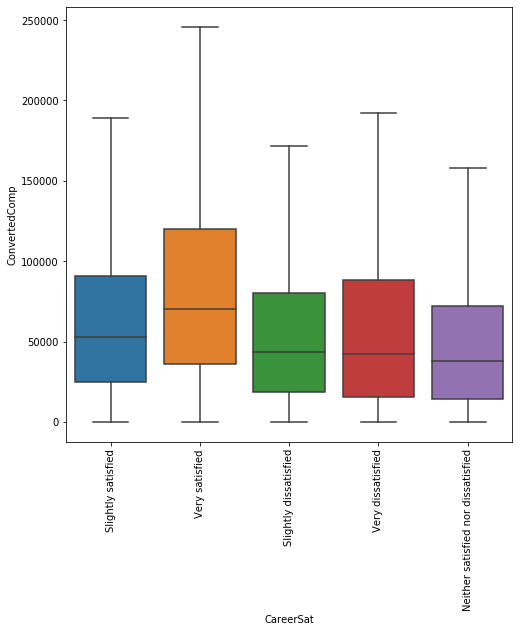

In [29]:
figure = plt.figure(figsize=(8,8))
sb.boxplot(x="CareerSat", y="ConvertedComp", data=df_salary, showfliers=False)
plt.xticks(rotation=90);

In [30]:
df_salary.groupby("CareerSat")["ConvertedComp"].count()

CareerSat
Neither satisfied nor dissatisfied     4759
Slightly dissatisfied                  5692
Slightly satisfied                    19456
Very dissatisfied                      2659
Very satisfied                        23257
Name: ConvertedComp, dtype: int64

Satisfied tend to have a bigger compensation than the others. The opposite situation might have been surprising.  
It might be interesting to investigate further to see if there is realy a corelation between compensation and satisfaction. For instance, one might consider looking at the compensation weighted by the number of working hours. Another interesting point would be to know of what is made the compensation - whether it is only cash or if there are others advantages such as plane flights reimbursement for instance.  
Still one could say money does not make you happy but it helps. Or maybe it is because people are happy that they work better and so have higher compensations.